In [ ]:
# default_exp analyses

# Probability of First Recall
> The first recall a participant makes in a free recall experiment 

## Data Preparation
For our demonstrations, we'll lean on the MurdockOkada1970 dataset. 
As a reminder, in this dataset each of 72 undergraduates was given 20 test lists with 20-word lists visually presented at either 60 or 120 words/min.

In [ ]:
from compmemlearn.datasets import prepare_murdock1970_data

trials, events, list_length = prepare_murdock1970_data("../../data/mo1970.txt")
events.head()


,subject,list,item,input,output,study,recall,repeat,intrusion
0,1,1,1,1,NaN,True,False,0,False
1,1,1,2,2,NaN,True,False,0,False
2,1,1,3,3,NaN,True,False,0,False
3,1,1,4,4,NaN,True,False,0,False
4,1,1,5,5,NaN,True,False,0,False


## Analysis

### DataFrame
We can usually rely on the `psifr` library to generate `pandas` DataFrames containing PFR information. 

In [ ]:
from psifr import fr

pfr = fr.pnr(events).query("output <= 1")
pfr


prob  actual  possible
subject output input                        
1       1      1      0.00       0        20
               2      0.00       0        20
               3      0.00       0        20
               4      0.00       0        20
               5      0.00       0        20
...                    ...     ...       ...
72      1      16     0.05       1        20
               17     0.50      10        20
               18     0.15       3        20
               19     0.10       2        20
               20     0.05       1        20

[1440 rows x 3 columns]

### Fast Array Generation
`DataFrame`s contain granular subject-by-subject information and are easier to plot using the `seaborn` library. 
But sometimes we don't need this granular information and mainly want to perform our analysis as quickly as possible -- perhaps to help with model fitting or analysis. 
In that case, representing results with `numpy` arrays and performing just-in-time compilation of our function using `numba` might be preferred. 
We include `analyses.fast_crp` in our library for that purpose here.

In [ ]:
# export

from numba import njit
import numpy as np


@njit(fastmath=True, nogil=True)
def fast_pfr(trials, item_count):
    return np.bincount(trials[:, 0], minlength=item_count + 1)[1:] / len(trials)


In [ ]:
fast_pfr(trials, list_length)

array([0.06666667, 0.00347222, 0.00208333, 0.00208333, 0.00416667,
       0.00138889, 0.00694444, 0.00416667, 0.00763889, 0.01458333,
       0.00902778, 0.01597222, 0.03055556, 0.03472222, 0.05694444,
       0.09027778, 0.13402778, 0.18611111, 0.15347222, 0.17569444])

We can compare the runtimes of `compmemlearn`'s and `psifr`'s functions using the `%%timeit` Jupyter magic:

In [ ]:
%%timeit
fast_pfr(trials, list_length)

3.88 µs ± 87.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [ ]:
%%timeit
fr.pnr(events)

530 ms ± 4.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Our fast implementation is more than 100,000 times faster!

## Plotting
`psifr`'s plotting library creates a separate figure for each plot, when sometimes we want to to include multiple plots in one figure, so we define our own.

In [ ]:
# export
import seaborn as sns
from psifr import fr


def plot_pfr(data, **facet_kws):

    pfr_data = fr.pnr(data).query("output <= 1")

    sns.lineplot(data=pfr_data, x="input", y="prob", **facet_kws)


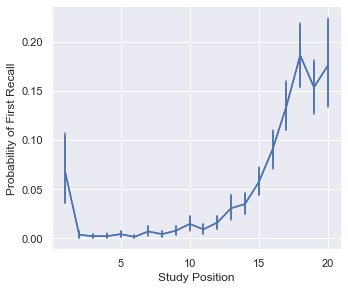

In [ ]:
sns.set_theme(style="darkgrid")

g = sns.FacetGrid(dropna=False, data=events, height=4, aspect=1.2)
g.map_dataframe(plot_pfr, err_style="bars")

g.set_xlabels("Study Position")
g.set_ylabels("Probability of First Recall")
